In [1]:
import numpy as np
import sys
sys.path.insert(0,'/Users/yohai/workspace/faultSlip/')
from faultSlip.profiles import Profile
from faultSlip.inversion import Inversion
import matplotlib.pyplot as plt

In [2]:
strike = np.radians(137)
pn = np.array([ np.sin(strike), np.cos(strike)])

In [3]:

30.26 - pn[0] * 20, 70.02 - pn[1] * 20

(16.62003279875003, 84.6470740323834)

In [4]:
par = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":0,
	"strike_element":1,
	"open_element":0,
	"compute_mean":false,
	"boundary_constrained":false,
	"origin_lon":-118.1,
	"origin_lat":35.3
	},
"plains":
	{
	"plain1":
		{
		"dip":90.0,
		"strike":137.0,
		"plain_cord":[16.62003279875003, 84.6470740323834, 0.1],
		"plain_length":100.0,
		"width":[1.3, 5.3, 5.3, 9.1, 9.1],
		"num_sub_stk":[8, 8, 4, 4, 2],
		"smooth_up":[],
		"strike_element":-1,
		"dip_element":0,
			"total_width":10
		}
	},
"profiles":
    {
    "profile1":
        {
            "x":"/Users/yohai/workspace/east_california/okada/resamp_cx_2.npy",
            "y":"/Users/yohai/workspace/east_california/okada/resamp_cy_2.npy",
            "data":"/Users/yohai/workspace/east_california/okada/resamp_disp2.npy",
            "uncertentices":"/Users/yohai/workspace/east_california/okada/resamp_inter2.npy",
            "heading":-13.13,
            "incidence_angle":0
        },
    "profile2":
        {
            "x":"/Users/yohai/workspace/east_california/okada/resamp_cx_3.npy",
            "y":"/Users/yohai/workspace/east_california/okada/resamp_cy_3.npy",
            "data":"/Users/yohai/workspace/east_california/okada/resamp_disp3.npy",
            "uncertentices":"/Users/yohai/workspace/east_california/okada/resamp_inter3.npy",
            "heading":-13.13,
            "incidence_angle":0
        }
    },
"gps":
    {
    "gps1":
        {
            "data":"/Users/yohai/workspace/east_california/static_inversion/gnss_disp.csv",
            "origin_lat":35.3,
            "origin_lon":-118.1
        }
    }
}'''

with open('__t.par', 'w') as f:
    f.write(par)
inv = Inversion('./__t.par')

(<Figure size 432x288 with 1 Axes>,
 <Axes3DSubplot:title={'center':'Fault Geometry'}>)

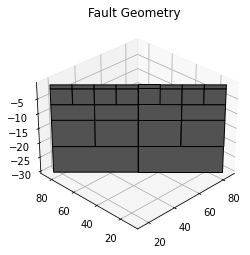

In [5]:
inv.build_kers()
inv.plot_sources()

In [6]:
def get_g(inv, G_kw):
    alpha = G_kw['alpha']
    beta = G_kw['beta']
    Gp1 = np.concatenate((inv.profiles[0].G_ss, inv.profiles[0].G_ds, inv.profiles[0].G_o), axis=1)
    Gp2 = np.concatenate((inv.profiles[1].G_ss, inv.profiles[1].G_ds, inv.profiles[1].G_o), axis=1)
    Ggnss = inv.gps[0].G_ss[:inv.gps[0].data.shape[0] * 2]
    S = inv.new_smoothing()
    G = np.concatenate((Gp1, Gp2, Ggnss * alpha, S * beta), axis=0)
    bgnss = np.concatenate((inv.gps[0].data.E.values, inv.gps[0].data.N.values))
    b = np.concatenate((inv.profiles[0].data, inv.profiles[1].data, alpha * bgnss, np.zeros(S.shape[0])))
    return b, G
def calc_misfit(inv, slip):
    Gp1 = np.concatenate((inv.profiles[0].G_ss, inv.profiles[0].G_ds, inv.profiles[0].G_o), axis=1)
    Gp2 = np.concatenate((inv.profiles[1].G_ss, inv.profiles[1].G_ds, inv.profiles[1].G_o), axis=1)
    Ggnss = inv.gps[0].G_ss[:inv.gps[0].data.shape[0] * 2]
    G = np.concatenate((Gp1, Gp2, Ggnss), axis=0)
    bgnss = np.concatenate((inv.gps[0].data.E.values, inv.gps[0].data.N.values))
    b = np.concatenate((inv.profiles[0].data, inv.profiles[1].data, bgnss))
    return np.linalg.norm(G.dot(slip) - b, 2) / b.shape[0]


0.000818300681586739


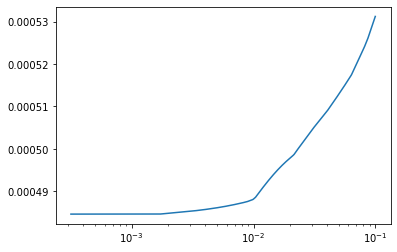

In [7]:
betas = np.logspace(-3.5, -1, 1000)
costs = []
for beta in betas:    
    inv.solve_g(get_g, {'alpha':0.977, 'beta':beta})
    costs.append(calc_misfit(inv, inv.solution))
plt.figure()
plt.plot(betas, costs)
plt.xscale('log')
print(betas[np.argmin(costs)])

0.9885417021919574


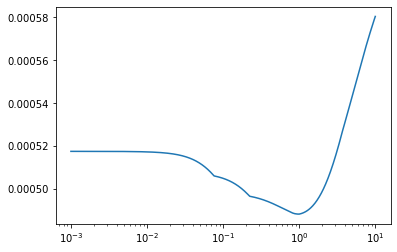

In [8]:

alphas = np.logspace(-3, 1, 1000)
costs = []
for alpha in alphas:    
    inv.solve_g(get_g, {'alpha':alpha, 'beta':0.01})
    costs.append(calc_misfit(inv, inv.solution))
plt.figure()
plt.plot(alphas, costs)
plt.xscale('log')
print(alphas[np.argmin(costs)])

(<Figure size 432x288 with 2 Axes>,
 <Axes3DSubplot:title={'center':'Total Slip'}>)

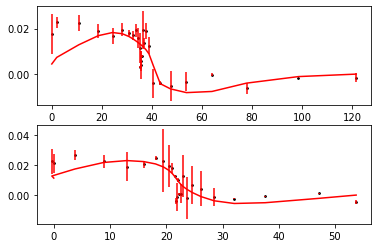

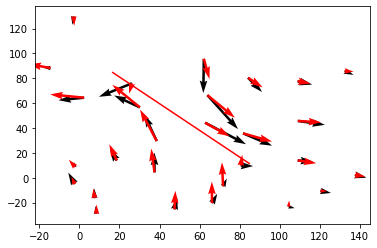

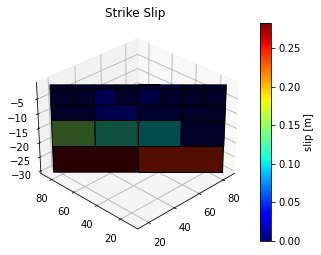

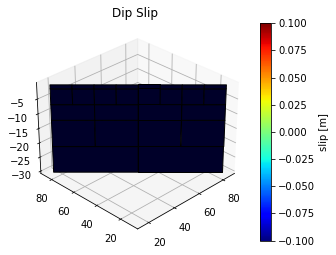

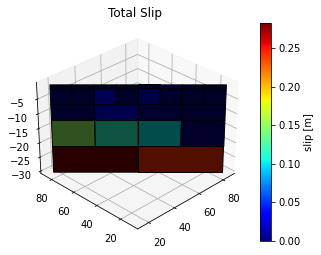

In [7]:

inv.solve_g(get_g, {'alpha':0.988, 'beta':0.01})
inv.plot_profiles(slip=inv.solution)
ax = inv.gps[0].plot_en(slip=inv.solution)
faul_x, fault_y = inv.get_fault()
ax.plot(faul_x[0], fault_y[0], color='r')
inv.plot_sources(slip=np.concatenate((inv.solution, np.zeros_like(inv.solution))))

In [8]:
from scipy.stats import linregress

In [13]:
linregress(inv.profiles[0].data, inv.profiles[0].get_model(inv.solution).squeeze())

LinregressResult(slope=0.6630961413651768, intercept=0.0017013501633445591, rvalue=0.7790077169353129, pvalue=1.6948245748533072e-06, stderr=0.10674368877979397, intercept_stderr=0.0014592774987090746)

In [14]:
linregress(inv.profiles[1].data, inv.profiles[1].get_model(inv.solution).squeeze())

LinregressResult(slope=0.669565272006151, intercept=0.0025149300436747837, rvalue=0.8064169375234246, pvalue=1.130468515159837e-06, stderr=0.10237927216824923, intercept_stderr=0.0015015707281842586)

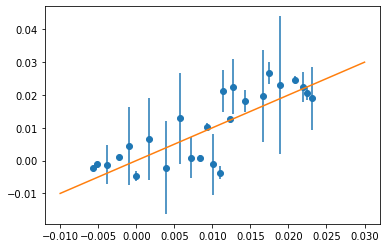

In [20]:
plt.scatter(inv.profiles[1].get_model(inv.solution).squeeze(), inv.profiles[1].data)
plt.errorbar(inv.profiles[1].get_model(inv.solution).squeeze(), inv.profiles[1].data, yerr=inv.profiles[1].uncertentices, linestyle='None')
plt.plot([-0.01, 0.03], [-0.01, 0.03])

In [21]:
Gp1 = np.concatenate((inv.profiles[0].G_ss, inv.profiles[0].G_ds, inv.profiles[0].G_o), axis=1)
Gp2 = np.concatenate((inv.profiles[1].G_ss, inv.profiles[1].G_ds, inv.profiles[1].G_o), axis=1)
Ggnss = inv.gps[0].G_ss[:inv.gps[0].data.shape[0] * 2]
G = np.concatenate((Gp1, Gp2, Ggnss), axis=0)
bgnss = np.concatenate((inv.gps[0].data.E.values, inv.gps[0].data.N.values))
b = np.concatenate((inv.profiles[0].data, inv.profiles[1].data, bgnss))
m = G.dot(inv.solution)

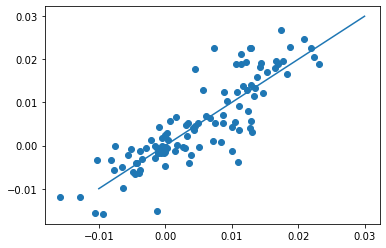

In [24]:
plt.scatter(m, b)
plt.plot([-0.01, 0.03], [-0.01, 0.03])

In [27]:
linregress(b, m)

LinregressResult(slope=0.7369514829298147, intercept=0.001157557207685927, rvalue=0.8578976099601037, pvalue=1.9926171000751644e-32, stderr=0.042870849155901974, intercept_stderr=0.00047597413019455804)